In [1]:
import cv2
from io import BytesIO
import ipywidgets
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
from picamera import PiCamera
import rpyc

In [2]:
img=cv2.imread('gerald-way-umbrella-academy-1.jpg')

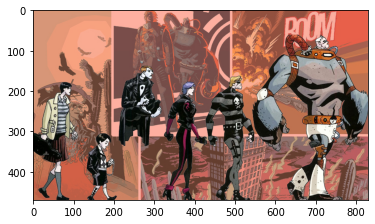

In [3]:
img_clr = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
plt.imshow(img_clr)

In [4]:
camera = PiCamera()
camera.resolution = (640,480)
camera.start_preview()

In [5]:
# Using video capture greatly speeds up the responsiveness (quality is less of course)
# It is possible to capture even faster using capture_sequence
# Documentation is on the following URL, since it complicates the code, it's probably best to leave this as a last resort
# https://picamera.readthedocs.io/en/release-1.13/recipes2.html#rapid-capture-and-processing
stream = BytesIO()
camera.capture(stream, format='jpeg', use_video_port=True)

In [6]:
# this code shows the more general stream capturing, however it's much easier to cirectly capture to an array
# See the update_image function below
stream.seek(0)
cam_img = cv2.imdecode(np.frombuffer(stream.read(), np.uint8), 1)
cam_img_clr = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGBA)

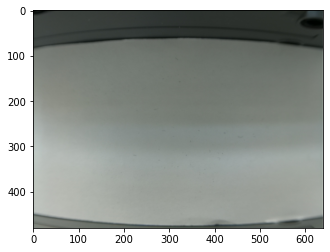

In [7]:
plt.imshow(cam_img_clr)

In [8]:
image_widget = ipywidgets.Image(format='jpeg')
image_widget.value = bytes(cv2.imencode('.jpg', cam_img_clr)[1])
display(image_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [9]:
processed_widget = ipywidgets.Image(format='jpeg')
display(processed_widget)

Image(value=b'', format='jpeg')

In [51]:
def pre_process_image(image):
    without_borders = image[100:420,:]
    gray = cv2.cvtColor(without_borders, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    return gray
    
first_image = pre_process_image(cam_img_clr)

In [101]:
def update_image():
    cam_img = np.empty((640*480*3,), dtype=np.uint8)
    camera.capture(cam_img, format='bgr', use_video_port=True)
    cam_img = cam_img.reshape((480,640,3))
    
    gray = pre_process_image(cam_img)
    
    image_diff = cv2.absdiff(first_image, gray)
    thresh = cv2.threshold(image_diff, 40, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)
    #thresh = cv.Canny(thresh, 40, 80)
    # Find contours
    #_, contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)


    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < 20:
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        if w > 600 or w < 50:
            continue
        cv2.rectangle(cam_img, (x, y+100), (x + w, y + h + 100), (0, 255, 0), 2)

    image_widget.value = bytes(cv2.imencode('.jpg', cam_img)[1])
    processed_widget.value = bytes(cv2.imencode('.jpg', thresh)[1])

In [98]:
import threading
from time import sleep
running = True
def update_image_loop():
    while running:
        update_image()
        
t = threading.Thread(target=update_image_loop)
t.start()

In [35]:
ev3_ip = '192.168.50.222'
ev3_connection = rpyc.classic.connect(ev3_ip)
ev3dev2_motor = ev3_connection.modules['ev3dev2.motor']

In [36]:
camera_motor = ev3dev2_motor.MediumMotor(ev3dev2_motor.OUTPUT_A)

In [102]:
camera_motor.on_for_rotations(ev3dev2_motor.SpeedPercent(50), 5)

In [103]:
running = False
t.join()

In [104]:
camera.stop_preview()
camera.close()